Kelompok 4

Deteksi Tumor Otak dengan Metode Convolutional Neural Network

IT 05-01

Nama Anggota:
1. Maharani Febhi Atha Ningrum (1202220006)
2. Adinda Mariasti Dewi (1202220041)
3. Wahyuning Ajeng Arfiatin (1202220045)
4. Adina Fadillah Balqis (1202222012)

Tumor otak merupakan salah satu penyakit paling mematikan di dunia. Berdasarkan data dari WHO, jumlah kasus baru tumor otak di Indonesia mencapai 5.323 kasus, dengan angka kematian menempati urutan ke-13 sebanyak 4.229 kasus. Tumor otak terbagi menjadi tiga jenis utama, yaitu glioma, meningioma, dan pituitary. Untuk mendeteksi keberadaan tumor otak, dokter biasanya menggunakan MRI (Magnetic Resonance Imaging) Scan. Namun, proses untuk menentukan jenis tumor secara spesifik membutuhkan waktu. Oleh karena itu, kami bermaksud mengembangkan sebuah sistem yang dapat membantu dokter dalam mengidentifikasi jenis tumor otak dengan lebih cepat dan efisien.
Kami melakukan penelitian identifikasi tumor otak menggunakan Convolutional Neural Network (CNN), datasets yang digunakan berupa gambar yang terdiri dari meningioma tumor, glioma tumor, pituitary tumor, dan normal. Algoritma yang digunakan pada penelitian ini memiliki kelebihan yaitu mampu mengekstraksi
fitur kompleks secara otomatis dan efisien untuk klasifikasi citra dengan skala yang besar.

Dataset yang kita gunakan dibagi menjadi 4 kategori, yaitu glioma tumor, meningioma tumor, pituitary tumor, dan normal

![flowchart keseluruhan.drawio.png](<attachment:flowchart keseluruhan.drawio.png>)
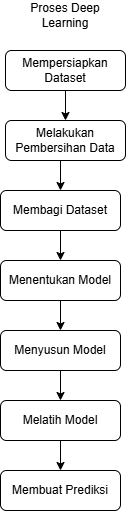

# **A. Pre-Processing**

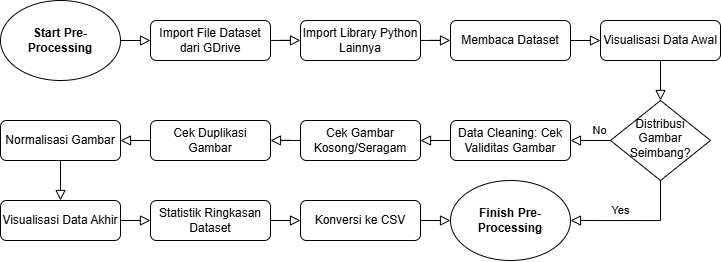

In [29]:
# Standar Library
import os
import csv
import hashlib

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Handling
from PIL import Image

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

1. Masalah yang Ingin Diselesaikan
Deteksi dini terhadap tumor otak melalui pencitraan medis, khususnya Magnetic Resonance Imaging (MRI), merupakan tantangan penting dalam bidang kesehatan. Identifikasi manual oleh ahli radiologi memerlukan waktu dan keahlian tinggi, sehingga penggunaan teknologi pengolahan citra digital dan pembelajaran mesin (machine learning) dapat mempercepat proses diagnosis secara otomatis. Proyek ini bertujuan mengklasifikasikan jenis tumor otak dari citra MRI ke dalam beberapa kategori, yaitu meningioma tumor, pituitary tumor, glioma tumor, dan no tumor.

2. Dataset yang Digunakan
Dataset yang digunakan berasal dari situs Kaggle, berjudul “Brain Tumor Classification (MRI)”, dan berisi total 2.870 citra MRI otak sebelum dilakukan pembersihan. Dataset ini diklasifikasikan ke dalam empat kategori, yaitu:

- Meningioma tumor

- Pituitary tumor

- Glioma tumor

- No tumor

Setiap citra merupakan gambar berformat .jpg dengan variasi resolusi yang kemudian diseragamkan melalui proses pre-processing.

3. Pre-processing Dataset
Agar gambar dapat digunakan untuk proses pelatihan model, dilakukan beberapa tahap pre-processing sebagai berikut:

Pembacaan Dataset → Konversi RGB → Resize → Normalisasi:

Pembacaan Dataset: Harus dilakukan pertama untuk mengidentifikasi data yang akan diproses.

Konversi RGB: Menentukan format warna yang sesuai dengan model (RGB untuk MobileNetV2) sebelum memodifikasi struktur citra.

Resize: Menyeragamkan dimensi citra untuk memastikan konsistensi input ke model, dilakukan setelah format warna ditetapkan.

Normalisasi: Menyesuaikan skala nilai piksel untuk optimasi pelatihan, dilakukan terakhir karena bergantung pada array piksel yang sudah seragam.

Urutan ini logis karena setiap langkah membangun hasil dari langkah sebelumnya, memastikan citra siap untuk pelatihan atau pengujian dengan format dan skala yang sesuai.

Data set ini terdiri dari gambar MRI otak yang dikelompokkan ke dalam dua folder: **dengan tumor**  atau **tanpa tumor**. Disini akan membaca nama-nama folder dan menyiapkan data untuk diproses lebih lanjut. Ini penting agar komputer tau bagaimana memisahkan dan mengolah data berdasarkan labelnya.

In [18]:
# Pengaturan Path dan Membaca Dataset
dataset_path = "Dataset Kanker Otak\Training"
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Membaca gambar dan menyimpan informasi dalam DataFrame
data = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        data.append((img_path, category))

df = pd.DataFrame(data, columns=['image_path', 'label'])

print("\nJumlah data gambar per kategori (valid):")
category_counts = df['label'].value_counts()
for category, count in category_counts.items():
    print(f"{category}: {count} gambar")


Jumlah data gambar per kategori (valid):
pituitary_tumor: 827 gambar
glioma_tumor: 826 gambar
meningioma_tumor: 822 gambar
no_tumor: 395 gambar


### Glioma Tumor

![gg (8).jpg](<attachment:gg (8).jpg>)

### Meningioma Tumor

![m (27).jpg](<attachment:m (27).jpg>)

### Pituitary Tumor

![p (23).jpg](<attachment:p (23).jpg>)

### No Tumor

![image (18).jpg](<attachment:image (18).jpg>)

Sebelum melakukan pembersihan data, kami menampilkan beberapa contoh gambar dari setiap kelas. Tujuannya adalah untuk mendapatkan gambaran awal mengenai kualitas data, format gambar, dan memastikan bahwa isi dataset sesuai dengan yang diharapkan.

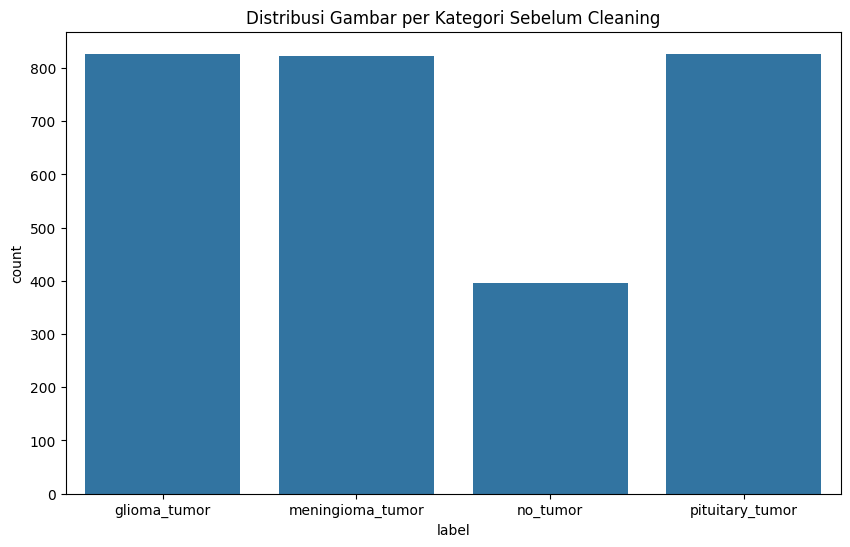

Total gambar sebelum cleaning: 2870


In [26]:
# Visualisasi Awal
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.title('Distribusi Gambar per Kategori Sebelum Cleaning')
plt.show()

print(f"Total gambar sebelum cleaning: {len(df)}")

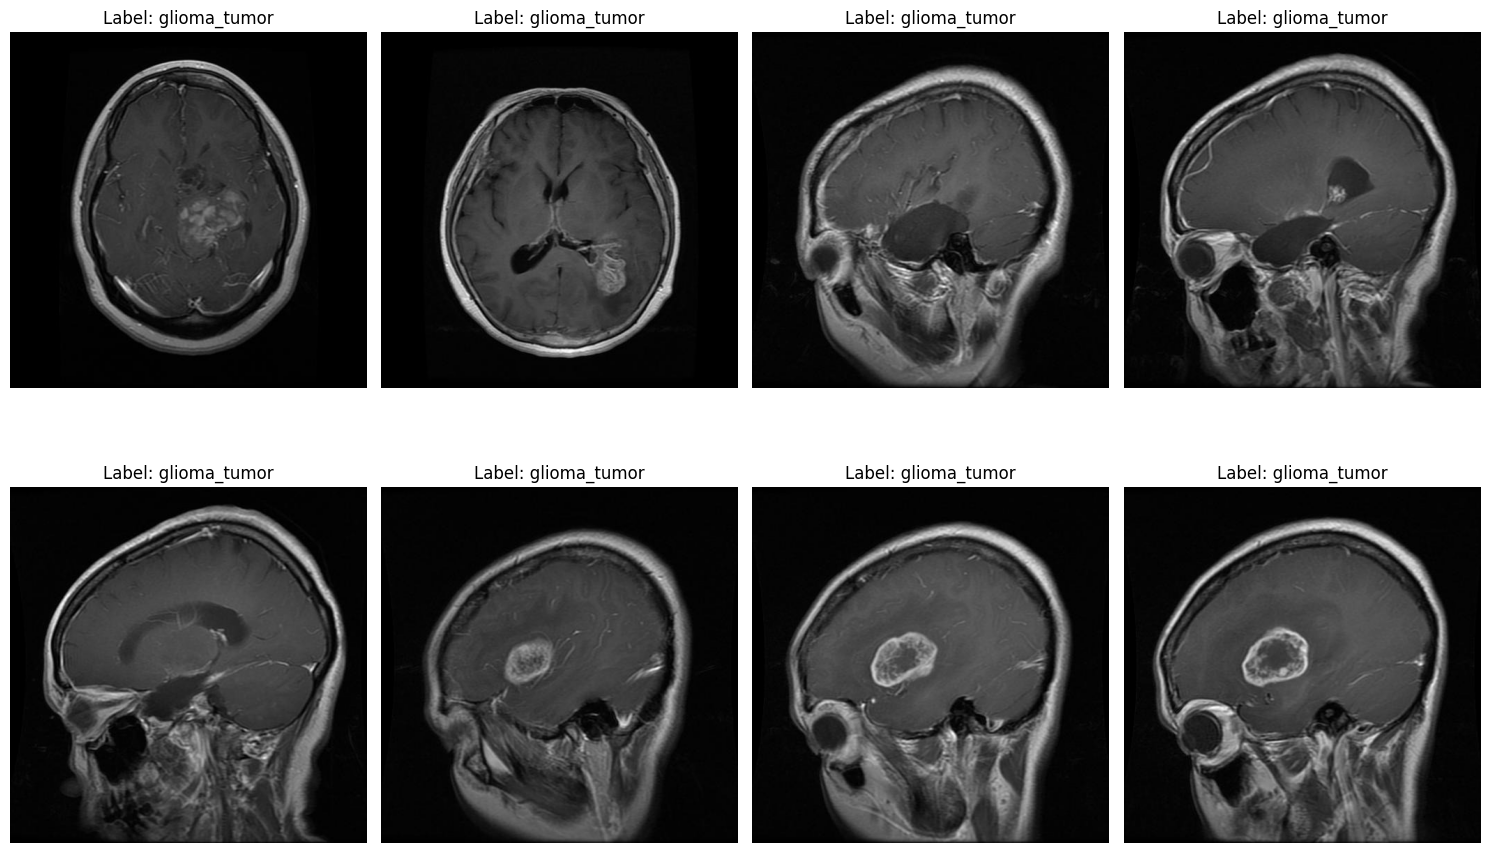

In [20]:
# --- Atur jumlah gambar yang ingin ditampilkan ---
num_images_to_show = 8

# --- Tampilkan beberapa gambar pertama dari dataset ---
plt.figure(figsize=(15, 10))

for i in range(min(num_images_to_show, len(df))):
    img_path = df.iloc[i]['image_path']
    label = df.iloc[i]['label']

    # Buka gambar dan konversi ke RGB jika perlu
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"❌ Gagal membuka gambar {img_path}: {e}")
        continue

    # Tampilkan gambar
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Kategori no_tumor memiliki jumlah gambar paling sedikit, sehingga dataset ini **tidak seimbang (inbalanced)**. Ketidakseimbangan ini perlu diperhatikan karena bisa memengaruhi performa model saat pelatihan, terutama dalam mengenali gambar tanpa tumor.

Fungsi check_image_validity:
a. Mengecek apakah file gambar valid dengan mencoba membuka dan memverifikasi gambar menggunakan library PIL (Python Imaging Library).
b. Jika berhasil, return True. Jika gagal (misal file corrupt/bukan gambar), cetak error dan return False.

In [4]:
# Fungsi Cek Validitas Gambar
def check_image_validity(img_path):
    try:
        img = Image.open(img_path)
        img.verify()
        return True
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return False

# Proses Data Cleaning
df['valid'] = df['image_path'].apply(check_image_validity)
df = df[df['valid']]

Proses Data Cleaning:
a. Menambahkan kolom 'valid' ke dataframe yang berisi True/False tergantung validitas gambar.
b. Menyaring dataframe hanya untuk baris yang memiliki gambar valid (df = df[df['valid']]), menghapus baris dengan gambar tidak valid

In [5]:
# Fungsi Cek Gambar Kosong (hampir seragam/hitam/putih)
def is_blank_or_noise(img_path, std_threshold=10):
    try:
        img = Image.open(img_path).convert('L')
        img_arr = np.array(img)
        return np.std(img_arr) < std_threshold
    except:
        return True  # Anggap error sebagai kosong/noise

df['is_blank_or_noise'] = df['image_path'].apply(is_blank_or_noise)
df = df[~df['is_blank_or_noise']]

Fungsi get_image_hash bertujuan untuk mengidentifikasi gambar duplikat dalam sebuah DataFrame dengan memanfaatkan teknik hashing berbasis konten gambar. Pertama, gambar dikonversi ke mode grayscale dan diubah ukurannya menjadi 64x64 piksel untuk standarisasi. Kemudian, gambar diubah menjadi array numpy dan dikonversi ke dalam bentuk byte, yang selanjutnya dihitung nilai hash MD5-nya untuk menghasilkan tanda unik (fingerprint) dari gambar tersebut. Proses ini memungkinkan pendeteksian gambar yang identik atau sangat mirip berdasarkan konten pixelnya. Setelah nilai hash dihasilkan, kode tersebut menambahkan kolom img_hash ke DataFrame, menghapus entri yang gagal diproses (jika ada), dan membersihkan duplikat dengan mempertahankan hanya satu contoh untuk setiap hash unik. Pendekatan ini efisien untuk menemukan gambar-gambar yang sama secara visual, meskipun mungkin memiliki nama atau metadata yang berbeda.

In [6]:
# Fungsi Hash Gambar untuk Duplikasi
def get_image_hash(img_path):
    try:
        img = Image.open(img_path).convert('L').resize((64, 64))
        img_arr = np.array(img)
        img_bytes = img_arr.tobytes()
        return hashlib.md5(img_bytes).hexdigest()
    except:
        return None

df['img_hash'] = df['image_path'].apply(get_image_hash)
df = df.dropna(subset=['img_hash'])
df = df.drop_duplicates(subset='img_hash', keep='first')

Gambar akan di resize ke ukuran 256 x 256. Data juga akan dirubah ke float32 dari numpy. Untuk menghindari data yang kurang akurat, apabila normalisasi menemukan kegagalan, maka gambar tersebut tidak akan diberikan.

In [7]:
def normalize_image(img_path):
    try:
        img = Image.open(img_path).convert('L').resize((256, 256))
        img_arr = np.array(img).astype(np.float32)
        img_arr = img_arr / 255.0  # Normalisasi
        return img_arr
    except:
        return None

df['normalized_image'] = df['image_path'].apply(normalize_image)

# Drop jika gagal dinormalisasi
df = df[df['normalized_image'].notnull()]

Data akhir akan dihitung untuk dilihat mana saja yang termasuk ke data yang sudah di cleaning dan di normalisasi.

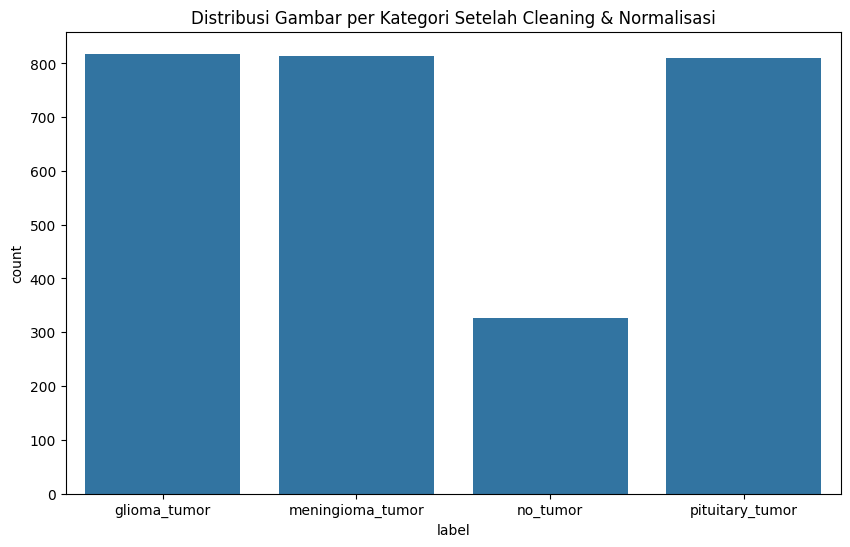

Total gambar siap digunakan: 2769


In [8]:
# Visualisasi Akhir
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.title('Distribusi Gambar per Kategori Setelah Cleaning & Normalisasi')
plt.show()

print(f"Total gambar siap digunakan: {len(df)}")

In [9]:
# Ringkasan Statistik Setelah Cleaning & Normalisasi
print("Jumlah total gambar per kategori setelah cleaning:")
print(df['label'].value_counts())

print("\nContoh dimensi dan nilai piksel dari 1 gambar:")
sample_img = df['normalized_image'].iloc[0]
print(f"Dimensi: {sample_img.shape}")
print(f"Nilai min: {np.min(sample_img)}, max: {np.max(sample_img)}, mean: {np.mean(sample_img):.4f}, std: {np.std(sample_img):.4f}")

print("\nStatistik keseluruhan dataset:")
means = df['normalized_image'].apply(lambda x: np.mean(x))
stds = df['normalized_image'].apply(lambda x: np.std(x))
print(f"Rata-rata piksel (mean) semua gambar: {means.mean():.4f}")
print(f"Rata-rata deviasi standar (std) semua gambar: {stds.mean():.4f}")

Jumlah total gambar per kategori setelah cleaning:
label
glioma_tumor        818
meningioma_tumor    814
pituitary_tumor     810
no_tumor            327
Name: count, dtype: int64

Contoh dimensi dan nilai piksel dari 1 gambar:
Dimensi: (256, 256)
Nilai min: 0.0, max: 0.9215686321258545, mean: 0.1053, std: 0.1428

Statistik keseluruhan dataset:
Rata-rata piksel (mean) semua gambar: 0.1781
Rata-rata deviasi standar (std) semua gambar: 0.1735


Code berikut ini bertujuan untuk mengonversi dataset gambar tumor otak yang telah dinormalisasi ke dalam format CSV, sehingga memudahkan proses analisis lebih lanjut atau digunakan untuk pelatihan model machine learning.
Prosesnya dimulai dengan menyiapkan direktori output menggunakan `os.makedirs()`, yang secara otomatis membuat folder baru jika belum ada. File CSV kemudian disimpan dalam path yang ditentukan, dalam code ini `processed_brain_tumor_data.csv`.

In [10]:
# Pastikan folder tujuan ada
output_folder = "/content/drive/MyDrive/Dataset Kanker Otak"
os.makedirs(output_folder, exist_ok=True)

# Path untuk file CSV output
output_path = os.path.join(output_folder, "processed_brain_tumor_data.csv")

Header CSV disusun dengan kolom pertama berupa "label”, yang kemungkinan berisi klasifikasi jenis tumor, diikuti oleh 512 kolom pixel (format `pixel_0`, `pixel_1`, dst.). Angka 512 ini didapat dari perhitungan `256 + 256`, mengindikasikan bahwa gambar asli memiliki dimensi 256x256 piksel.
Fungsi utama, `save_to_csv()`, bertugas menulis data ke dalam file CSV. Pertama, fungsi ini menulis header yang telah disiapkan. Kemudian, untuk setiap baris dalam DataFrame (`df`), gambar yang telah dinormalisasi diratakan (flatten) dan nilai setiap piksel diformat menjadi string dengan presisi empat angka desimal. Nilai-nilai piksel ini digabungkan dengan label tumor, membentuk sebuah baris data yang kemudian ditulis ke dalam CSV. Jika terjadi error saat pemrosesan suatu gambar, pesan error akan ditampilkan tanpa menghentikan eksekusi keseluruhan program.

In [11]:
# Define header outside the function
total_pixels = 256 * 256
header = ["label"] + [f"pixel_{i}" for i in range(total_pixels)]

# Revised function with header passed as argument
def save_to_csv(df, output_path, header):
    with open(output_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)  # Write header
        # Process each row
        for _, row in df.iterrows():
            try:
                # Flatten and format image data
                image_flat = row['normalized_image'].flatten()
                pixel_values = [f"{val:.4f}" for val in image_flat]

                # Combine label and pixels
                row_data = [row['label']] + pixel_values
                writer.writerow(row_data)
            except Exception as e:
                print(f"Error processing {row['image_path']}: {e}")

Setelah proses selesai, sistem menampilkan ringkasan output, termasuk lokasi penyimpanan file CSV, ukuran file (1212 MB), dan jumlah total baris (2770 baris, termasuk header). Code ini sangat berguna dalam proyek pengolahan data medis karena mengubah data gambar menjadi format terstruktur (numerik) yang kompatibel dengan berbagai alat analisis dan machine learning.

In [12]:
# Call the function with header argument
save_to_csv(df, output_path, header)

print(f"\nData berhasil disimpan sebagai file CSV di:")
print(f"{output_path}")
print(f"\nUkuran file: {os.path.getsize(output_path)//1024**2} MB")
print(f"Jumlah baris: {len(df)+1} (termasuk header)")


Data berhasil disimpan sebagai file CSV di:
/content/drive/MyDrive/Dataset Kanker Otak\processed_brain_tumor_data.csv

Ukuran file: 1212 MB
Jumlah baris: 2770 (termasuk header)


# **B. Penanganan Inbalanced Data**

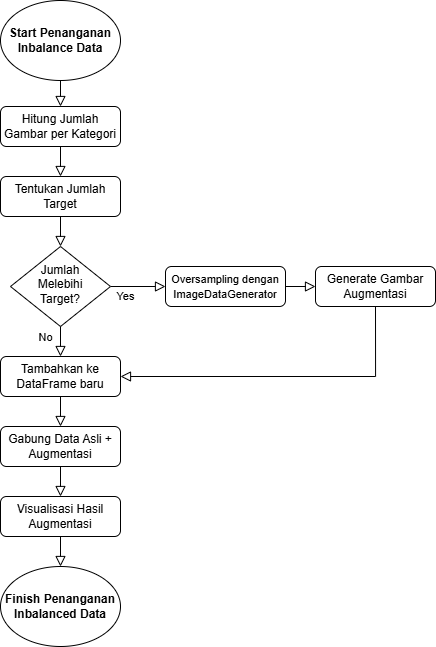

Kode tersebut menunjukkan proses augmentasi data untuk menyeimbangkan distribusi kelas dalam dataset gambar medis yang terdiri dari empat kategori: glioma_tumor, meningioma_tumor, pituitary_tumor, dan no_tumor. Target augmentasi adalah menyesuaikan jumlah gambar setiap kategori dengan jumlah maksimum (818 gambar) menggunakan ImageDataGenerator, yang akan menghasilkan variasi gambar baru melalui transformasi seperti rotasi, pergeseran, flipping horizontal, dan zoom untuk meningkatkan keragaman data dan mencegah overfitting selama pelatihan model.

In [12]:
# Distribusi data setelah cleaning (dari input Anda)
data_counts = {
    'glioma_tumor': 818,
    'meningioma_tumor': 814,
    'pituitary_tumor': 810,
    'no_tumor': 327
}

# Target jumlah gambar per kategori (jumlah maksimum)
target_count = max(data_counts.values())
print(f"Target jumlah gambar per kategori: {target_count}")

# Inisialisasi ImageDataGenerator untuk augmentasi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

Target jumlah gambar per kategori: 818


# Define oversample images

Disini, kita membuat fungsi untuk melakukan oversampling menggunakan augmentasi. Data count akan menyimpan jumlah gambar per kategori. Lalu, diambil jumlah maksimum dari nilai dalam data_counts untuk menambah jumlah sampel. Augmentasi berfungsi untuk menciptakan variasi gambar baru, yang meningkatkan jumlah data pelatihan dan variasi.

Fungsi ini menerima DataFrame asli (df), jumlah target (target_count), dan daftar kategori (categories). Ia melakukan iterasi melalui setiap kategori. Data asli untuk kategori tersebut ditambahkan ke list augmented_data. Jika jumlah data asli kurang dari target_count, fungsi menghitung berapa banyak sampel tambahan yang dibutuhkan. Sampel acak diambil dari data asli kategori tersebut sejumlah sampel tambahan yang diperlukan. Untuk setiap sampel acak ini, ImageDataGenerator (datagen) digunakan untuk membuat satu versi gambar yang diaugmentasi. Gambar augmentasi ini (bersama path asli dan labelnya) ditambahkan ke augmented_data. Setelah memproses semua kategori, augmented_data dikonversi menjadi DataFrame baru (df_oversampled). Lalu dilakukan oengecekan untuk tiap kategori agar memiliki jumlah target_count yang tepat.

# Def Visualise Augmentation

Fungsi ini membantu memvisualisasikan efek augmentasi. Ia mengambil beberapa contoh gambar asli dan beberapa contoh gambar yang telah diaugmentasi dari kategori tertentu dan menampilkannya berdampingan menggunakan matplotlib.

Fungsi ini dirancang untuk menangani masalah ketidakseimbangan kelas dalam dataset. Ia melakukan oversampling pada kelas-kelas minoritas dengan cara membuat versi gambar yang diaugmentasi (menggunakan ImageDataGenerator yang telah dikonfigurasi) hingga jumlah sampel di setiap kelas mencapai jumlah target target_count. Hasilnya adalah DataFrame baru yang lebih seimbang antar kelas.

In [13]:
# Fungsi untuk oversampling menggunakan augmentasi
def oversample_images(df, target_count, categories):
    augmented_data = []

    for category in categories:
        df_category = df[df['label'] == category]
        current_count = len(df_category)

        # Tambahkan data asli
        for _, row in df_category.iterrows():
            augmented_data.append((row['image_path'], category, row['normalized_image']))

        if current_count < target_count:
            # Hitung jumlah gambar tambahan yang diperlukan
            additional_samples = target_count - current_count
            print(f"Augmentasi {additional_samples} gambar untuk kategori {category}")

            # Ambil sampel acak untuk augmentasi
            sample_df = df_category.sample(n=additional_samples, replace=True, random_state=42)

            # Generate gambar augmentasi
            for _, row in sample_df.iterrows():
                img_array = row['normalized_image']
                img_array = img_array.reshape((1, 256, 256, 1))  # Sesuaikan dengan dimensi gambar

                aug_iter = datagen.flow(img_array, batch_size=1)
                augmented_data.append((row['image_path'], category, next(aug_iter)[0].reshape(256, 256)))

                # Hentikan jika sudah cukup
                if len([x for x in augmented_data if x[1] == category]) >= target_count:
                    break

    # Buat DataFrame baru dari data asli dan augmentasi
    df_oversampled = pd.DataFrame(augmented_data, columns=['image_path', 'label', 'normalized_image'])

    # Pastikan jumlah gambar per kategori tepat target_count
    final_data = []
    for category in categories:
        df_category = df_oversampled[df_oversampled['label'] == category]
        if len(df_category) > target_count:
            # Ambil tepat target_count gambar tanpa duplikasi
            sampled_df = df_category.sample(n=target_count, replace=False, random_state=42)
        else:
            sampled_df = df_category
        final_data.append(sampled_df)

    df_oversampled = pd.concat(final_data, ignore_index=True)
    return df_oversampled

# Fungsi untuk menampilkan gambar asli dan augmentasi
def visualize_augmentation(df, df_oversampled, category, num_samples=3):
    # Ambil gambar asli dari kategori tertentu
    original_images = df[df['label'] == category]['normalized_image'].head(num_samples).tolist()
    # Ambil gambar augmentasi dari kategori tertentu (pastikan bukan gambar asli)
    df_augmented = df_oversampled[df_oversampled['label'] == category]
    augmented_images = df_augmented['normalized_image'].tail(num_samples).tolist()

    # Visualisasi
    plt.figure(figsize=(15, 5))

    # Gambar asli
    for i, img in enumerate(original_images):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Original {category} #{i+1}')
        plt.axis('off')

    # Gambar augmentasi
    for i, img in enumerate(augmented_images):
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(img, cmap='gray')
        plt.title(f'Augmented {category} #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Lalu, untuk oversample, Fungsi ini bertujuan untuk memvisualisasikan hasil dari proses augmentasi data. Ia menampilkan beberapa contoh gambar asli dari kategori tertentu berdampingan dengan beberapa contoh gambar yang telah dihasilkan melalui augmentasi untuk kategori yang sama, memungkinkan inspeksi visual terhadap efek transformasi yang diterapkan.

Augmentasi 4 gambar untuk kategori meningioma_tumor
Augmentasi 491 gambar untuk kategori no_tumor
Augmentasi 8 gambar untuk kategori pituitary_tumor


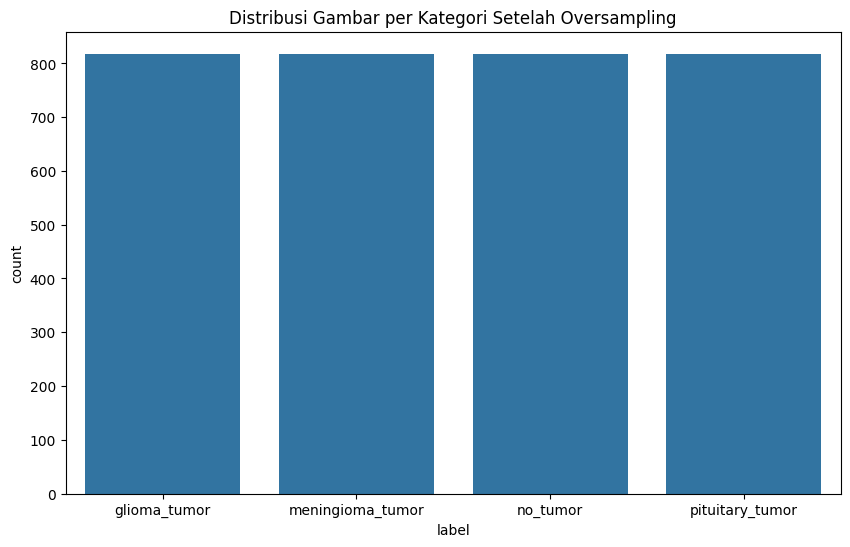

Jumlah total gambar per kategori setelah oversampling:
label
glioma_tumor        818
meningioma_tumor    818
no_tumor            818
pituitary_tumor     818
Name: count, dtype: int64
Total gambar setelah oversampling: 3272


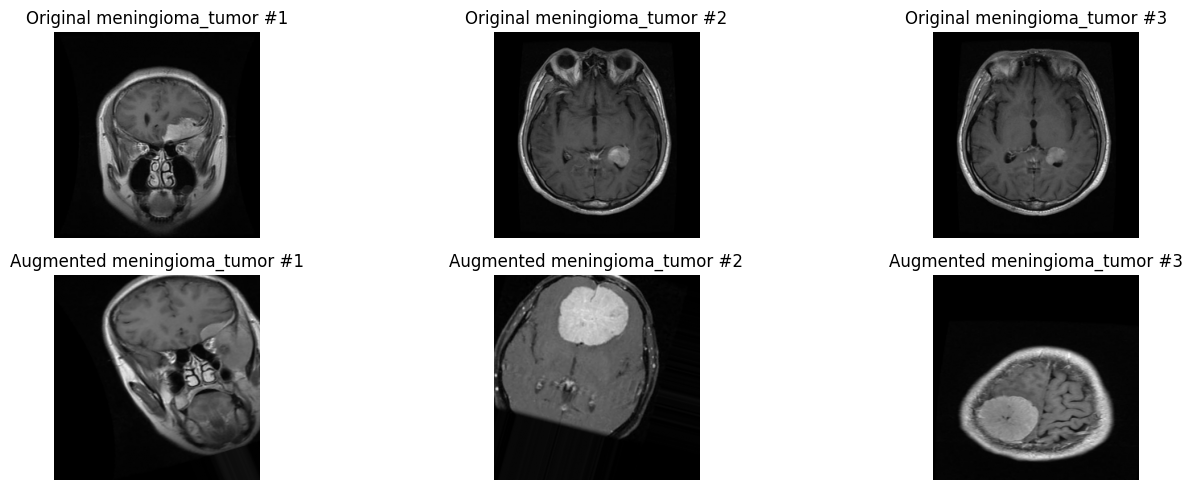

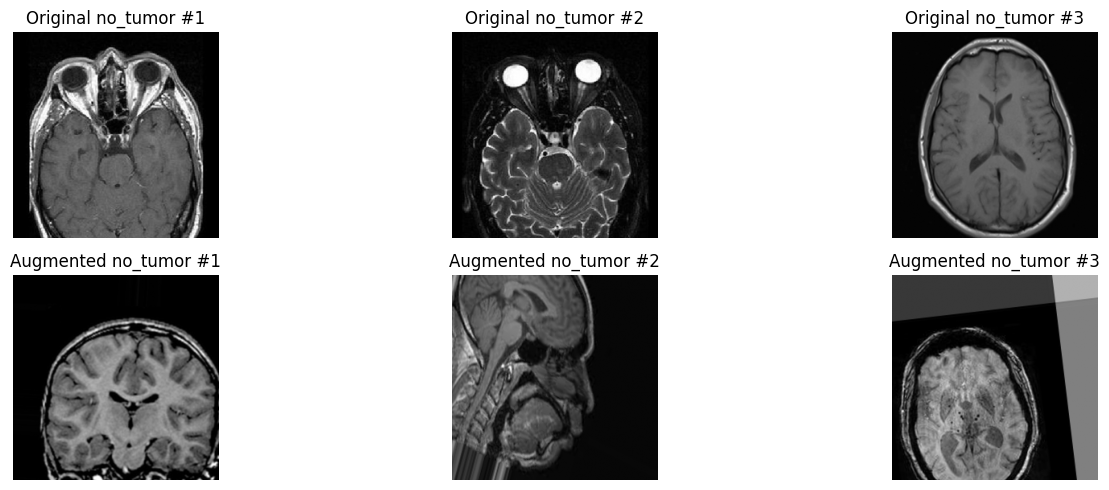

<Figure size 1500x500 with 0 Axes>


Statistik keseluruhan dataset setelah oversampling:
Rata-rata piksel (mean) semua gambar: 0.1849
Rata-rata deviasi standar (std) semua gambar: 0.1787


In [14]:
df_oversampled = oversample_images(df, target_count, categories)

# Visualisasi distribusi setelah oversampling
plt.figure(figsize=(10, 6))
sns.countplot(data=df_oversampled, x='label')
plt.title('Distribusi Gambar per Kategori Setelah Oversampling')
plt.show()

# Ringkasan distribusi setelah oversampling
print("Jumlah total gambar per kategori setelah oversampling:")
print(df_oversampled['label'].value_counts())

# Verifikasi jumlah total gambar
print(f"Total gambar setelah oversampling: {len(df_oversampled)}")

# Visualisasi beberapa gambar asli dan augmentasi untuk kategori 'meningioma_tumor'
visualize_augmentation(df, df_oversampled, 'meningioma_tumor', num_samples=3)
# Visualisasi beberapa gambar asli dan augmentasi untuk kategori 'no_tumor'
visualize_augmentation(df, df_oversampled, 'no_tumor', num_samples=3)
# Visualisasi beberapa gambar asli dan augmentasi untuk kategori 'ituitary_tumor'
visualize_augmentation(df, df_oversampled, 'ituitary_tumor', num_samples=3)

# Verifikasi statistik gambar setelah oversampling
print("\nStatistik keseluruhan dataset setelah oversampling:")
means = df_oversampled['normalized_image'].apply(lambda x: np.mean(x))
stds = df_oversampled['normalized_image'].apply(lambda x: np.std(x))
print(f"Rata-rata piksel (mean) semua gambar: {means.mean():.4f}")
print(f"Rata-rata deviasi standar (std) semua gambar: {stds.mean():.4f}")

Apa itu Mean dan Standar Deviasi untuk Gambar?

Mean (Rata-rata Intensitas Piksel): Untuk satu gambar, mean adalah nilai rata-rata dari semua tingkat kecerahan (intensitas) piksel dalam gambar tersebut. Jika gambar dinormalisasi ke rentang [0, 1], nilai mean yang mendekati 0 berarti gambar cenderung gelap, nilai mendekati 1 berarti gambar cenderung terang, dan nilai sekitar 0.5 berarti kecerahan rata-ratanya abu-abu. Ini memberikan gambaran umum tentang kecerahan gambar.
Standard Deviation (Deviasi Standar Intensitas Piksel): Untuk satu gambar, standar deviasi mengukur seberapa besar variasi atau sebaran nilai intensitas piksel di dalam gambar tersebut dari nilai rata-ratanya (mean). Nilai standar deviasi yang rendah (mendekati 0) berarti piksel-piksel dalam gambar memiliki intensitas yang cenderung seragam (kontras rendah). Nilai standar deviasi yang tinggi berarti intensitas piksel sangat bervariasi (kontras tinggi, banyak detail atau perbedaan antara area terang dan gelap).


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Simulasi Data dengan array float32 ---
data = {
    'normalized_image': [
        (np.random.rand(128, 128) * 0.1 + 0.05).astype(np.float32),  # low mean, low std
        (np.random.rand(128, 128) * 0.1 + 0.45).astype(np.float32),  # high mean, low std
        (np.random.rand(128, 128) * 0.4 + 0.05).astype(np.float32),  # low mean, high std
        (np.random.rand(128, 128) * 0.4 + 0.45).astype(np.float32),  # high mean, high std
        (np.random.rand(128, 128) * 0.2 + 0.25).astype(np.float32),  # mid mean, mid std
    ] * 4,
    'label': ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor'] * 4
}
df = pd.DataFrame(data)

# --- Periksa apakah DataFrame kosong ---
if df.empty:
    print("DataFrame is empty. Cannot proceed.")
else:
    try:
        # --- Hitung mean dan std dev untuk setiap gambar ---
        mean_intensities = df['normalized_image'].apply(
            lambda x: np.mean(x) if isinstance(x, np.ndarray) else np.nan
        )
        std_deviations = df['normalized_image'].apply(
            lambda x: np.std(x) if isinstance(x, np.ndarray) else np.nan
        )

        # --- Filter data valid yang benar-benar array ---
        valid_indices = mean_intensities.dropna().index & std_deviations.dropna().index
        df_valid = df.loc[valid_indices].copy()
        df_valid['mean'] = mean_intensities.loc[valid_indices]
        df_valid['std'] = std_deviations.loc[valid_indices]

        if df_valid.empty:
            print("No valid image data found.")
        else:
            # --- Tampilkan tabel ringkasan mean dan std ---
            print("\n📊 Tabel Ringkasan Mean & Std Dev untuk Setiap Gambar:")
            table_summary = df_valid[['label', 'mean', 'std']].copy()
            table_summary.index.name = 'Index'
            print(table_summary.round(4))

            # --- Hitung threshold kuartil ---
            mean_threshold_low = df_valid['mean'].quantile(0.25)
            mean_threshold_high = df_valid['mean'].quantile(0.75)
            std_threshold_low = df_valid['std'].quantile(0.25)
            std_threshold_high = df_valid['std'].quantile(0.75)

            print(f"\nThreshold Mean: Low < {mean_threshold_low:.4f}, High > {mean_threshold_high:.4f}")
            print(f"Threshold Std Dev: Low < {std_threshold_low:.4f}, High > {std_threshold_high:.4f}")

            # --- Pilih gambar berdasarkan kategori Mean/Std Dev ---
            selected_indices = {}

            idx_low_mean = df_valid[df_valid['mean'] < mean_threshold_low].index.max()
            if pd.notna(idx_low_mean):
                selected_indices['Low Mean'] = idx_low_mean

            idx_high_mean = df_valid[df_valid['mean'] > mean_threshold_high].index.min()
            if pd.notna(idx_high_mean):
                selected_indices['High Mean'] = idx_high_mean

            idx_low_std = df_valid[df_valid['std'] < std_threshold_low].index.max()
            if pd.notna(idx_low_std):
                selected_indices['Low Std Dev'] = idx_low_std

            idx_high_std = df_valid[df_valid['std'] > std_threshold_high].index.min()
            if pd.notna(idx_high_std):
                selected_indices['High Std Dev'] = idx_high_std

            
    except Exception as e:
        print(f"❌ Terjadi error: {e}")


📊 Tabel Ringkasan Mean & Std Dev untuk Setiap Gambar:
                  label    mean     std
Index                                  
0              no_tumor  0.0999  0.0290
1      meningioma_tumor  0.4998  0.0289
2          glioma_tumor  0.2504  0.1153
3       pituitary_tumor  0.6502  0.1157
4              no_tumor  0.3500  0.0574
5              no_tumor  0.0999  0.0290
6      meningioma_tumor  0.4998  0.0289
7          glioma_tumor  0.2504  0.1153
8       pituitary_tumor  0.6502  0.1157
9              no_tumor  0.3500  0.0574
10             no_tumor  0.0999  0.0290
11     meningioma_tumor  0.4998  0.0289
12         glioma_tumor  0.2504  0.1153
13      pituitary_tumor  0.6502  0.1157
14             no_tumor  0.3500  0.0574
15             no_tumor  0.0999  0.0290
16     meningioma_tumor  0.4998  0.0289
17         glioma_tumor  0.2504  0.1153
18      pituitary_tumor  0.6502  0.1157
19             no_tumor  0.3500  0.0574

Threshold Mean: Low < 0.2504, High > 0.4998
Threshold Std Dev: L

# Calculate Metrics

Fungsi utilitas ini mengotomatiskan proses evaluasi performa model klasifikasi. Ia menerima label sebenarnya dan label prediksi, menghitung metrik standar seperti akurasi, presisi (macro), recall (macro), dan F1-score (macro) menggunakan sklearn.metrics, lalu mencetaknya. Selain itu, fungsi ini juga menghasilkan dan menampilkan confusion matrix menggunakan seaborn untuk analisis performa per kelas yang lebih detail.

In [15]:
# Fungsi untuk menghitung metrik evaluasi
def calculate_metrics(true_labels, pred_labels, categories, method_name):
    print(f"\nMetrik Evaluasi untuk {method_name}:")
    print(f"Akurasi: {accuracy_score(true_labels, pred_labels):.4f}")
    print(f"Precision (macro): {precision_score(true_labels, pred_labels, average='macro', zero_division=0):.4f}")
    print(f"Recall (macro): {recall_score(true_labels, pred_labels, average='macro', zero_division=0):.4f}")
    print(f"F1-Score (macro): {f1_score(true_labels, pred_labels, average='macro', zero_division=0):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=categories)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title(f'Confusion Matrix - {method_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Metode 1: Klasifikasi Berdasarkan Rata-rata Intensitas Piksel
def classify_by_mean_intensity(df):
    # Hitung rata-rata intensitas piksel untuk setiap gambar
    mean_intensities = df['normalized_image'].apply(lambda x: np.mean(x))

    # Tentukan ambang batas berdasarkan statistik dataset
    mean_threshold_low = mean_intensities.quantile(0.25)  # 25th percentile
    mean_threshold_high = mean_intensities.quantile(0.75)  # 75th percentile

    # Klasifikasi heuristik
    pred_labels = []
    for mean in mean_intensities:
        if mean < mean_threshold_low:
            pred_labels.append('no_tumor')  # Intensitas rendah -> no_tumor
        elif mean < mean_threshold_high:
            pred_labels.append('meningioma_tumor')  # Intensitas sedang -> meningioma
        else:
            # Intensitas tinggi -> pilih antara glioma atau pituitary
            pred_labels.append('glioma_tumor' if mean > mean_intensities.mean() else 'pituitary_tumor')

    return pred_labels

# Metode 2: Klasifikasi Berdasarkan Deviasi Standar Piksel
def classify_by_std_deviation(df):
    # Hitung deviasi standar piksel untuk setiap gambar
    std_deviations = df['normalized_image'].apply(lambda x: np.std(x))

    # Tentukan ambang batas berdasarkan statistik dataset
    std_threshold_low = std_deviations.quantile(0.25)  # 25th percentile
    std_threshold_high = std_deviations.quantile(0.75)  # 75th percentile

    # Klasifikasi heuristik
    pred_labels = []
    for std in std_deviations:
        if std < std_threshold_low:
            pred_labels.append('no_tumor')  # Variasi rendah -> no_tumor
        elif std < std_threshold_high:
            pred_labels.append('meningioma_tumor')  # Variasi sedang -> meningioma
        else:
            # Variasi tinggi -> pilih antara glioma atau pituitary
            pred_labels.append('glioma_tumor' if std > std_deviations.mean() else 'pituitary_tumor')

    return pred_labels

Kita akan mengekstrak label untuk hasil dari masing-masing metode yang digunakan.

In [ ]:
# Ekstrak label sebenarnya
true_labels = df_oversampled['label'].values

# Metode 1: Evaluasi berdasarkan rata-rata intensitas piksel
pred_labels_mean = classify_by_mean_intensity(df_oversampled)
calculate_metrics(true_labels, pred_labels_mean, categories, "Metode Rata-rata Intensitas Piksel")

# Metode 2: Evaluasi berdasarkan deviasi standar piksel
pred_labels_std = classify_by_std_deviation(df_oversampled)
calculate_metrics(true_labels, pred_labels_std, categories, "Metode Deviasi Standar Piksel")

Berikut adalah visualisasi dari distribusi fitur untuk pemahaman yang lebih mudah dengan melihat rata-rata intensitas dan distribusi deviasi standar.

In [ ]:
# Visualisasi distribusi fitur untuk memahami klasifikasi
plt.figure(figsize=(12, 5))

# Plot distribusi rata-rata intensitas
plt.subplot(1, 2, 1)
for category in categories:
    means = df_oversampled[df_oversampled['label'] == category]['normalized_image'].apply(np.mean)
    sns.histplot(means, label=category, kde=True, stat='density')
plt.title('Distribusi Rata-rata Intensitas Piksel per Kategori')
plt.xlabel('Rata-rata Intensitas')
plt.legend()

# Plot distribusi deviasi standar
plt.subplot(1, 2, 2)
for category in categories:
    stds = df_oversampled[df_oversampled['label'] == category]['normalized_image'].apply(np.std)
    sns.histplot(stds, label=category, kde=True, stat='density')
plt.title('Distribusi Deviasi Standar Piksel per Kategori')
plt.xlabel('Deviasi Standar')
plt.legend()

plt.tight_layout()
plt.show()

# **C. Membuat Model CNN Dengan Transfer Learning (MobileNetV2)**

![model mobilenetv2.drawio.png](<attachment:model mobilenetv2.drawio.png>)
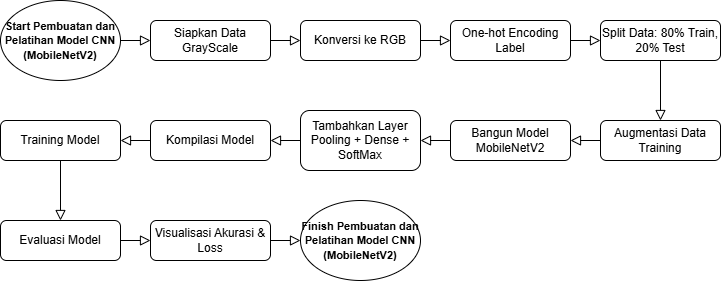

# Persiapan data gambar grayscale untuk digunakan dalam pelatihan model deep learning

Code berikut ini digunakan untuk mempersiapkan data gambar grayscale agar dapat digunakan dalam pelatihan model deep learning, seperti MobileNetV2 yang memerlukan input RGB. Data gambar diambil dari kolom 'normalized_image', lalu dikonversi menjadi bentuk RGB dengan menyalin channel grayscale sebanyak tiga kali. Label dikonversi menggunakan one-hot encoding. Setelah itu, data dibagi menjadi 80% data pelatihan dan 20% data pengujian dengan distribusi label yang seimbang.

Untuk meningkatkan performa model, diterapkan data augmentation pada data pelatihan menggunakan 'ImageDataGenerator' dengan rotasi, pergeseran, zoom, dan pembalikan horizontal. Generator untuk pelatihan dibuat dengan augmentasi, sedangkan generator untuk pengujian dibuat tanpa augmentasi dan dengan urutan data tetap (tidak diacak).

In [18]:
# Persiapkan data untuk pelatihan
X = np.stack(df_oversampled['normalized_image'].values)  # Shape: (3272, 256, 256)
y = pd.get_dummies(df_oversampled['label']).values  # One-hot encoding untuk label

# Konversi gambar grayscale ke RGB (MobileNetV2 membutuhkan input RGB)
X_rgb = np.repeat(X[..., np.newaxis], 3, axis=-1)  # Shape: (3272, 256, 256, 3)

# Bagi data menjadi train (80%) dan test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_rgb, y, test_size=0.2, stratify=df_oversampled['label'], random_state=42)

# Data augmentation untuk pelatihan
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Generator untuk data pelatihan
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# Generator untuk data pengujian (tanpa augmentasi)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Membangun, melatih, dan mengevaluasi model klasifikasi gambar menggunakan arsitektur MobileNetV2 sebagai feature extractor

Code berikut ini menunjukkan proses pembuatan dan pelatihan model klasifikasi gambar menggunakan MobileNetV2 feature extractor. Model dasar MobileNetV2 dimuat dengan bobot dari 'ImageNet' dan dibekukan agar tidak dilatih ulang. Selanjutnya, ditambahkan lapisan kustom berupa 'GlobalAveragePooling', dense layer, dan output layer dengan aktivasi softmax untuk klasifikasi 4 kelas.

Model dikompilasi dengan optimizer Adam, fungsi loss 'categorical_crossentropy', dan metrik akurasi. Proses pelatihan dilakukan selama 10 epoch menggunakan data augmentasi untuk pelatihan dan data asli untuk validasi. Setelah pelatihan, model dievaluasi pada data uji, hasil prediksi dan label asli dikonversi dari bentuk numerik ke nama kategori untuk memudahkan interpretasi hasil klasifikasi.

In [41]:
# Bangun model dengan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Bekukan lapisan MobileNetV2

# Tambahkan lapisan kustom
inputs = Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)  # 4 kelas
model = Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_test) // 32,
    verbose=1
)

# Evaluasi model pada set pengujian
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Konversi label numerik ke nama kategori
label_map = {i: cat for i, cat in enumerate(categories)}
y_pred_labels = [label_map[i] for i in y_pred_classes]
y_true_labels = [label_map[i] for i in y_true_classes]

C:\Users\Adinda\AppData\Local\Temp\ipykernel_13104\3333927527.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 890ms/step - accuracy: 0.6195 - loss: 0.9160 - val_accuracy: 0.8203 - val_loss: 0.4671
Epoch 2/10
 1/81 ━━━━━━━━━━━━━━━━━━━━ 40s 507ms/step - accuracy: 0.8438 - loss: 0.5056

c:\Users\Adinda\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.8438 - loss: 0.5056 - val_accuracy: 0.8156 - val_loss: 0.4855
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 71s 871ms/step - accuracy: 0.8562 - loss: 0.4039 - val_accuracy: 0.8219 - val_loss: 0.4396
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.9062 - loss: 0.2494 - val_accuracy: 0.7859 - val_loss: 0.4703
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 897ms/step - accuracy: 0.8683 - loss: 0.3171 - val_accuracy: 0.8453 - val_loss: 0.3750
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.7500 - loss: 0.5224 - val_accuracy: 0.8344 - val_loss: 0.3741
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9137 - loss: 0.2511 - val_accuracy: 0.8453 - val_loss: 0.3956
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.8438 - loss: 0.2915 - val_accuracy: 0.8328 - val_loss: 0.4218
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 899ms/step - accuracy: 0.9100 - loss: 0.2425 - val_accuracy: 0.8625 -

## Evaluasi Model CNN Dengan Transfer Learning (MobileNetV2)

Code berikut ini digunakan untuk mengevaluasi performa model dan memvisualisasikan hasil pelatihan. Fungsi 'calculate_metrics' menghitung metrik evaluasi seperti akurasi, precision, recall, dan F1-score berdasarkan label prediksi dan label sebenarnya. Selanjutnya, dilakukan visualisasi berupa dua grafik: grafik pertama menampilkan perkembangan akurasi pelatihan dan validasi selama epoch, sedangkan grafik kedua menampilkan nilai loss untuk pelatihan dan validasi. Visualisasi ini membantu memahami apakah model mengalami overfitting atau underfitting. Fungsi 'plt.tight_layout()' digunakan di akhir untuk memastikan tata letak grafik tertata rapi dan tidak saling tumpang tindih.


Metrik Evaluasi untuk MobileNetV2 Transfer Learning:
Akurasi: 0.8489
Precision (macro): 0.8478
Recall (macro): 0.8486
F1-Score (macro): 0.8478


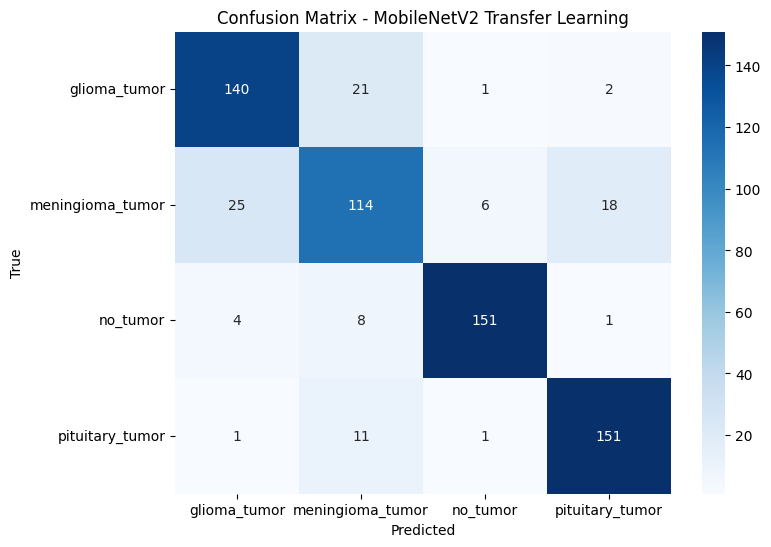

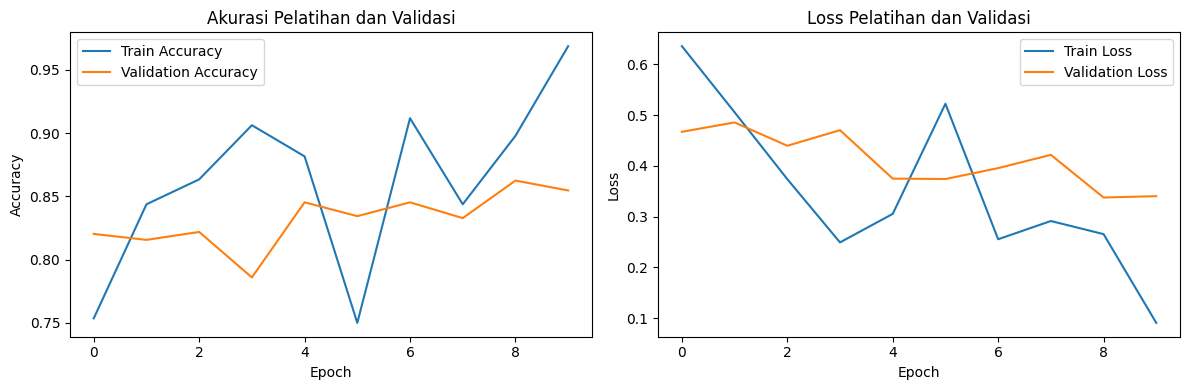

In [50]:
# Hitung metrik evaluasi
calculate_metrics(y_true_labels, y_pred_labels, categories, "MobileNetV2 Transfer Learning")

# Visualisasi akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [51]:
predicted_labels_to_report = y_pred_labels  # Ganti dengan y_pred_labels_finetune jika fine-tuning dilakukan

# Cetak Classification Report
print("\nClassification Report:")
print(classification_report(y_true_labels, predicted_labels_to_report, target_names=categories, zero_division=0))


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.82      0.85      0.84       164
meningioma_tumor       0.74      0.70      0.72       163
        no_tumor       0.95      0.92      0.93       164
 pituitary_tumor       0.88      0.92      0.90       164

        accuracy                           0.85       655
       macro avg       0.85      0.85      0.85       655
    weighted avg       0.85      0.85      0.85       655



In [52]:
model.save('brain_tumor_model.h5')

# **D. Melakukan Tuning Pada MobileNetV2**

![tuning mobilenetv2.png](<attachment:tuning mobilenetv2.png>)
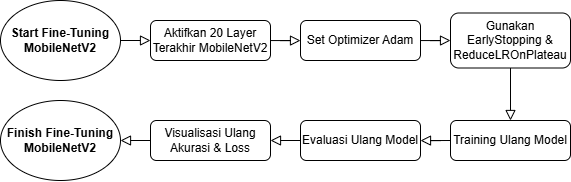

Code berikut ini menunjukkan proses fine-tuning model deep learning. Pertama, 20 lapisan terakhir dari model dasar 'base_model' diaktifkan agar dapat dilatih ulang. Model kemudian dikompilasi dengan optimizer Adam dan learning rate kecil (0.0001) untuk mencegah perubahan drastis pada bobot pretrained. Dua callback digunakan: 'EarlyStopping' untuk menghentikan pelatihan jika tidak ada peningkatan validasi loss, dan 'ReduceLROnPlateau' untuk menurunkan learning rate saat validasi loss stagnan.

Model dilatih menggunakan data generator selama 10 epoch dengan langkah-langkah per epoch yang disesuaikan. Setelah pelatihan, model dievaluasi dengan memprediksi kelas dari data uji, kemudian hasil prediksi dan label sebenarnya dikonversi dari format numerik ke nama kategori menggunakan peta label 'label_map'.

In [36]:
# Fine-tuning: Buka beberapa lapisan terakhir untuk pelatihan
for layer in base_model.layers[-20:]:  # Buka 20 lapisan terakhir
    layer.trainable = True

# Kompilasi model dengan learning rate lebih rendah untuk fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback untuk early stopping dan pengurangan learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Latih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    steps_per_epoch=len(X_train) // 16,
    validation_steps=len(X_test) // 16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluasi model pada set pengujian
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Konversi label numerik ke nama kategori
label_map = {i: cat for i, cat in enumerate(categories)}
y_pred_labels = [label_map[i] for i in y_pred_classes]
y_true_labels = [label_map[i] for i in y_true_classes]

Epoch 1/10
 82/163 ━━━━━━━━━━━━━━━━━━━━ 1:29 1s/step - accuracy: 0.9021 - loss: 0.2704

c:\Users\Adinda\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 625ms/step - accuracy: 0.9069 - loss: 0.2517 - val_accuracy: 0.8702 - val_loss: 0.4195 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 586ms/step - accuracy: 0.9599 - loss: 0.1047 - val_accuracy: 0.9145 - val_loss: 0.3188 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 616ms/step - accuracy: 0.9799 - loss: 0.0703 - val_accuracy: 0.8733 - val_loss: 0.4004 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 627ms/step - accuracy: 0.9824 - loss: 0.0453 - val_accuracy: 0.8824 - val_loss: 0.3554 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 627ms/step - accuracy: 0.9845 - loss: 0.0392 - val_accuracy: 0.9069 - val_loss: 0.3608 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 621ms/step - accuracy: 0.9907 - loss: 0.0314 - val_accuracy: 0.9252 - val_loss: 0.2896 - learning_rate: 2.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 620ms/s

## Evaluasi Hasil Tuning

Code berikut ini berfungsi untuk mengevaluasi performa model dan memvisualisasikan hasil pelatihan. Fungsi 'calculate_metrics' digunakan untuk menghitung metrik evaluasi seperti precision, recall, dan f1-score dengan membandingkan label prediksi dan label sebenarnya, serta menampilkan nama model yang digunakan melalui fungsi 'Fine-Tuned MobileNetV2'.

Selanjutnya, dibuat visualisasi dalam bentuk dua grafik: grafik pertama menampilkan akurasi pelatihan dan validasi terhadap jumlah epoch, sedangkan grafik kedua menunjukkan nilai loss untuk pelatihan dan validasi. Visualisasi ini membantu dalam menganalisis apakah model mengalami overfitting atau underfitting.


Metrik Evaluasi untuk Fine-Tuned MobileNetV2:
Akurasi: 0.9359
Precision (macro): 0.9379
Recall (macro): 0.9358
F1-Score (macro): 0.9362


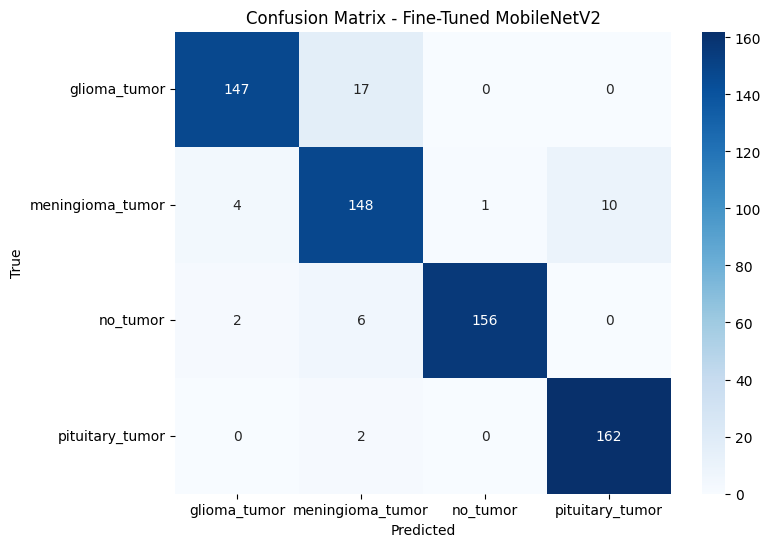

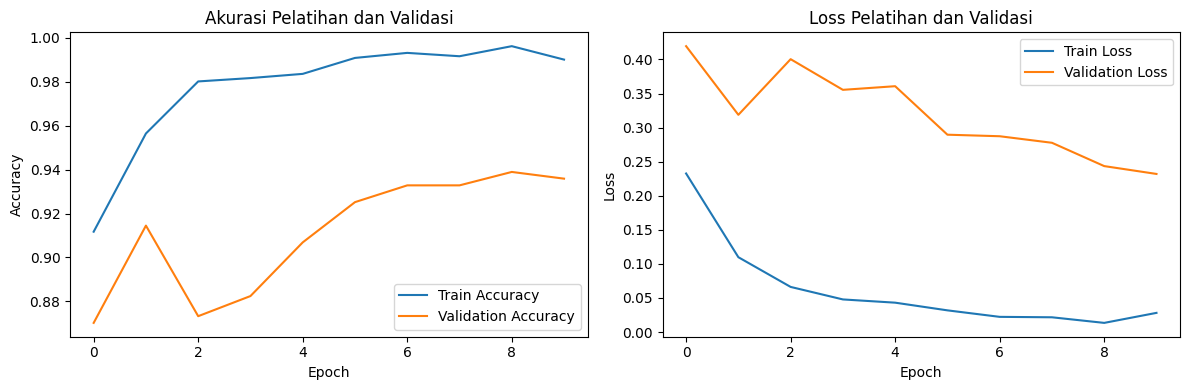

In [ ]:
# Hitung metrik evaluasi
calculate_metrics(y_true_labels, y_pred_labels, categories, "Fine-Tuned MobileNetV2")

# Visualisasi akurasi dan loss selama pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Pelatihan dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
predicted_labels_to_report = y_pred_labels  # Ganti dengan y_pred_labels_finetune jika fine-tuning dilakukan

# Cetak Classification Report
print("\nClassification Report:")
print(classification_report(y_true_labels, predicted_labels_to_report, target_names=categories, zero_division=0))


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.90      0.93       164
meningioma_tumor       0.86      0.91      0.88       163
        no_tumor       0.99      0.95      0.97       164
 pituitary_tumor       0.94      0.99      0.96       164

        accuracy                           0.94       655
       macro avg       0.94      0.94      0.94       655
    weighted avg       0.94      0.94      0.94       655



# Testing

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 577ms/step

Test Set Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.64      0.25      0.36       100
meningioma_tumor       0.57      0.80      0.66       115
        no_tumor       0.72      0.88      0.79       105
 pituitary_tumor       0.89      0.78      0.83        74

        accuracy                           0.68       394
       macro avg       0.70      0.68      0.66       394
    weighted avg       0.69      0.68      0.65       394



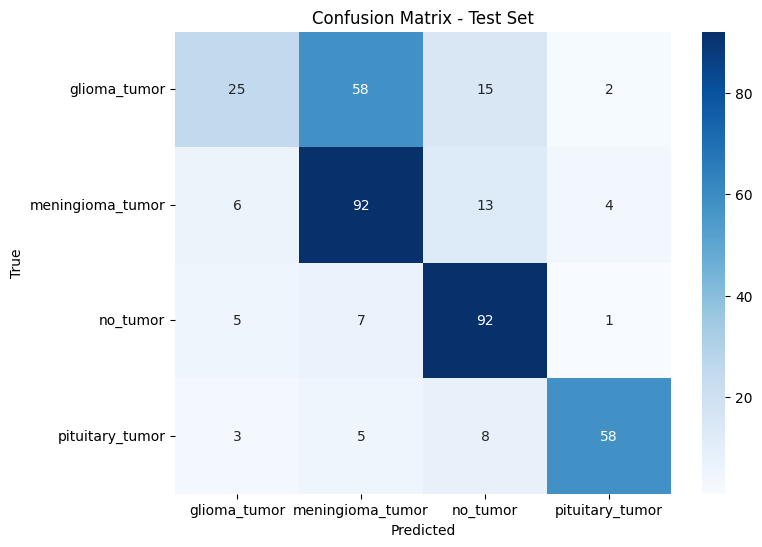

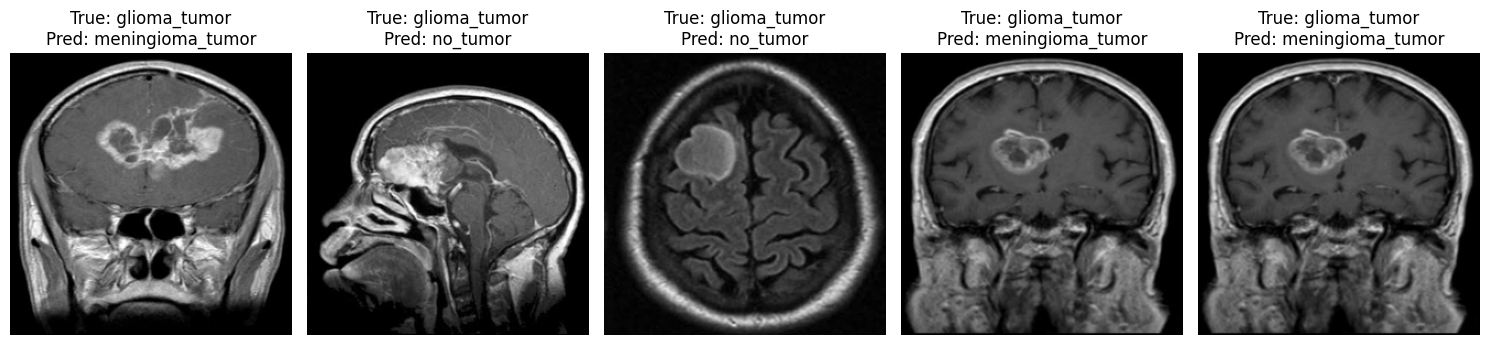

In [53]:
# Define paths and categories
test_dataset_path = "Dataset Kanker Otak\\Testing"  # Adjust this path to your test dataset directory
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
IMG_SIZE = (256, 256)  # Same size as used in training

# Function to preprocess a single image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB to match MobileNetV2 input
    img = img.resize(IMG_SIZE)  # Resize to 256x256
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Load the trained model
model = tf.keras.models.load_model('brain_tumor_model.h5')  # Replace with the path to your saved model

# Prepare test data
test_data = []
test_labels = []
for category in categories:
    category_path = os.path.join(test_dataset_path, category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        test_data.append(preprocess_image(img_path))
        test_labels.append(categories.index(category))

# Convert to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Make predictions
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate the model
print("\nTest Set Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=categories, zero_division=0))

# Compute and plot confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optional: Visualize some test predictions
num_samples = 5
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(test_data[i])
    plt.title(f"True: {categories[test_labels[i]]}\nPred: {categories[predicted_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
# -- coding: utf-8 --
"""
Script to evaluate a Keras model on an image dataset structured in subfolders,
identify misclassifications, and generate an Excel summary of error counts.
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from collections import defaultdict
from openpyxl import Workbook
from openpyxl.utils import get_column_letter

# --- Configuration (NEEDS USER ADJUSTMENT) --- 

# Path to the saved Keras model file
MODEL_PATH = 'brain_tumor_model.h5' # Assumes the model is in the same directory

# Path to the *Testing* dataset directory
# IMPORTANT: Assumes structure like: Test_Dataset_Path/category_name/image.jpg
# Example Windows: 'Dataset Kanker Otak\\Testing'
# Example macOS/Linux: 'Dataset Kanker Otak/Testing'
TEST_DATASET_PATH = 'Dataset Kanker Otak/Testing' # <<< --- *** ADJUST THIS PATH ***

# Image dimensions expected by the model (Check your notebook, common sizes are 150 or 224)
IMG_HEIGHT = 256
IMG_WIDTH = 256

# List of categories in the order the model expects them (usually alphabetical)
# This should match the subfolder names in your Testing directory
CATEGORIES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Output Excel file name
OUTPUT_EXCEL_PATH = 'misclassification_summary.xlsx'

# --- End Configuration ---

def preprocess_image(img_path):
#""Loads and preprocesses an image for the model."""
    try:
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        # Normalize pixel values (assuming model was trained with /255 scaling)
        img_array = img_array / 255.0
        # Expand dimensions to match model input shape (1, height, width, channels)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# --- Main Execution --- 


print("Starting misclassification analysis...")

# Check if test dataset path exists
if not os.path.isdir(TEST_DATASET_PATH):
    print(f"Error: Testing dataset directory not found at '{TEST_DATASET_PATH}'")
    print("Please check the TEST_DATASET_PATH variable in the script.")
    exit()

# Load the model
try:
    print(f"Loading model from {MODEL_PATH}...")
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# Dictionary to store counts of each misclassification type
# Key: (true_label, predicted_label), Value: count
misclassification_counts = defaultdict(int)
processed_images = 0
error_images = 0

print(f"Processing images in {TEST_DATASET_PATH}...")

# Iterate through each category subfolder in the test dataset
for true_label in CATEGORIES:
    category_path = os.path.join(TEST_DATASET_PATH, true_label)
    if not os.path.isdir(category_path):
        print(f"Warning: Category folder not found: {category_path}. Skipping.")
        continue

    print(f"  Processing category: {true_label}...")
    image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    for img_name in image_files:
        img_path = os.path.join(category_path, img_name)
        
        # Preprocess the image
        processed_img = preprocess_image(img_path)
        
        if processed_img is not None:
            processed_images += 1
            try:
                # Make prediction
                predictions = model.predict(processed_img)
                predicted_index = np.argmax(predictions[0])
                predicted_label = CATEGORIES[predicted_index]

                # Check for misclassification
                if true_label != predicted_label:
                    misclassification_counts[(true_label, predicted_label)] += 1
                    # Optional: print misclassified files
                    # print(f"    MISCLASSIFIED: {img_name} (True: {true_label}, Predicted: {predicted_label})")

            except Exception as e:
                print(f"Error predicting image {img_path}: {e}")
                error_images += 1
        else:
            error_images += 1
            
print(f"\nFinished processing {processed_images} images.")
if error_images > 0:
    print(f"Encountered errors processing/predicting {error_images} images.")

# Prepare data for Excel
excel_data = []
for (true, pred), count in misclassification_counts.items():
    excel_data.append({
        'True Label': true,
        'Predicted Label': pred,
        'Count': count
    })

if not excel_data:
    print("No misclassifications found or no data processed successfully.")
else:
    print(f"Found {len(excel_data)} types of misclassifications.")
    # Create DataFrame
    df = pd.DataFrame(excel_data)
    # Sort for consistency (optional)
    df = df.sort_values(by=['True Label', 'Predicted Label']).reset_index(drop=True)

    # Save to Excel using openpyxl for formatting
    print(f"Saving misclassification summary to {OUTPUT_EXCEL_PATH}...")
    try:
        wb = Workbook()
        ws = wb.active
        ws.title = "Misclassification Summary"

        # Write header
        ws.append(list(df.columns))

        # Write data rows
        for r_idx, row in enumerate(df.itertuples(index=False), 2): # Start from row 2
            for c_idx, value in enumerate(row, 1):
                ws.cell(row=r_idx, column=c_idx, value=value)

        # Adjust column widths
        for col_idx, column_title in enumerate(df.columns, 1):
            column_letter = get_column_letter(col_idx)
            max_length = len(column_title) # Start with header length
            for row_idx in range(2, ws.max_row + 1):
                cell_value = ws.cell(row=row_idx, column=col_idx).value
                if cell_value is not None and len(str(cell_value)) > max_length:
                    max_length = len(str(cell_value))
            adjusted_width = (max_length + 2)
            ws.column_dimensions[column_letter].width = adjusted_width

        wb.save(OUTPUT_EXCEL_PATH)
        print("Excel file saved successfully.")

    except Exception as e:
        print(f"Error saving Excel file: {e}")
        print("Attempting fallback save without formatting...")
        try:
                df.to_excel(OUTPUT_EXCEL_PATH + ".unformatted.xlsx", index=False)
                print("Unformatted Excel file saved successfully.")
        except Exception as e2:
                print(f"Fallback save failed: {e2}")

print("Script finished.")

Starting misclassification analysis...
Loading model from brain_tumor_model.h5...


Model loaded successfully.
Processing images in Dataset Kanker Otak/Testing...
  Processing category: glioma_tumor...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [10]:
# -- coding: utf-8 --
"""
Script to evaluate a Keras model on an image dataset structured in subfolders,
identify EACH misclassified image, and generate an Excel list detailing these errors.
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from openpyxl import Workbook
from openpyxl.utils import get_column_letter

# --- Configuration (NEEDS USER ADJUSTMENT) --- 

# Path to the saved Keras model file
MODEL_PATH = 'brain_tumor_model.h5' # Assumes the model is in the same directory

# Path to the *Testing* dataset directory
# IMPORTANT: Assumes structure like: Test_Dataset_Path/category_name/image.jpg
# Example Windows: 'Dataset Kanker Otak\\Testing'
# Example macOS/Linux: 'Dataset Kanker Otak/Testing'
TEST_DATASET_PATH = 'Dataset Kanker Otak/Testing' # <<< --- *** ADJUST THIS PATH ***

# Image dimensions expected by the model (MUST MATCH MODEL REQUIREMENTS)
IMG_HEIGHT = 256 # Adjusted based on previous error
IMG_WIDTH = 256 # Adjusted based on previous error

# List of categories in the order the model expects them (usually alphabetical)
# This should match the subfolder names in your Testing directory
CATEGORIES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Output Excel file name for the detailed list
OUTPUT_EXCEL_PATH = 'misclassification_details_list.xlsx'

# --- End Configuration ---

def preprocess_image(img_path):
    """Loads and preprocesses an image for the model."""
    try:
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img)
        # Normalize pixel values (assuming model was trained with /255 scaling)
        img_array = img_array / 255.0
        # Expand dimensions to match model input shape (1, height, width, channels)
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# --- Main Execution (Modified for detailed list) --- 

# Check if running as main script or in interactive environment
run_main = True 

if run_main:
    print("Starting detailed misclassification analysis...")

    # Check if test dataset path exists
    if not os.path.isdir(TEST_DATASET_PATH):
        print(f"Error: Testing dataset directory not found at '{TEST_DATASET_PATH}'")
        print("Please check the TEST_DATASET_PATH variable in the script.")
        exit()

    # Load the model
    try:
        print(f"Loading model from {MODEL_PATH}...")
        # Add compile=False if you encounter issues with custom objects/metrics loading
        model = tf.keras.models.load_model(MODEL_PATH, compile=False) 
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        exit()

    # List to store details of each misclassified image
    # Each item will be a dictionary: {'Image Filename': ..., 'True Label': ..., 'Predicted Label': ...}
    misclassified_files_list = []
    processed_images = 0
    error_images = 0

    print(f"Processing images in {TEST_DATASET_PATH}...")

    # Iterate through each category subfolder in the test dataset
    for true_label in CATEGORIES:
        category_path = os.path.join(TEST_DATASET_PATH, true_label)
        if not os.path.isdir(category_path):
            print(f"Warning: Category folder not found: {category_path}. Skipping.")
            continue

        print(f"  Processing category: {true_label}...")
        image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        
        for img_name in image_files:
            img_path = os.path.join(category_path, img_name)
            
            # Preprocess the image
            processed_img = preprocess_image(img_path)
            
            if processed_img is not None:
                processed_images += 1
                try:
                    # Make prediction
                    predictions = model.predict(processed_img, verbose=0) # Set verbose=0 to avoid progress bars per image
                    predicted_index = np.argmax(predictions[0])
                    predicted_label = CATEGORIES[predicted_index]

                    # Check for misclassification
                    if true_label != predicted_label:
                        # Store detailed information for this misclassified file
                        misclassified_files_list.append({
                            'Image Filename': img_name,
                            'True Label': true_label,
                            'Predicted Label': predicted_label
                        })
                        # Optional: print misclassified files
                        # print(f"    MISCLASSIFIED: {img_name} (True: {true_label}, Predicted: {predicted_label})")

                except Exception as e:
                    print(f"Error predicting image {img_path}: {e}")
                    error_images += 1
            else:
                error_images += 1
                
    print(f"\nFinished processing {processed_images} images.")
    if error_images > 0:
        print(f"Encountered errors processing/predicting {error_images} images.")

    # Prepare data for Excel
    if not misclassified_files_list:
        print("No misclassifications found or no data processed successfully.")
    else:
        print(f"Found {len(misclassified_files_list)} misclassified images.")
        # Create DataFrame from the list of dictionaries
        df = pd.DataFrame(misclassified_files_list)
        # Sort for consistency (optional)
        df = df.sort_values(by=['True Label', 'Image Filename']).reset_index(drop=True)

        # Save to Excel using openpyxl for formatting
        print(f"Saving detailed misclassification list to {OUTPUT_EXCEL_PATH}...")
        try:
            wb = Workbook()
            ws = wb.active
            ws.title = "Misclassification Details"

            # Write header
            ws.append(list(df.columns))

            # Write data rows
            for r_idx, row in enumerate(df.itertuples(index=False), 2): # Start from row 2
                for c_idx, value in enumerate(row, 1):
                    ws.cell(row=r_idx, column=c_idx, value=value)

            # Adjust column widths
            for col_idx, column_title in enumerate(df.columns, 1):
                column_letter = get_column_letter(col_idx)
                max_length = len(str(column_title)) # Start with header length
                for row_idx in range(2, ws.max_row + 1):
                    cell_value = ws.cell(row=row_idx, column=col_idx).value
                    if cell_value is not None and len(str(cell_value)) > max_length:
                        max_length = len(str(cell_value))
                adjusted_width = (max_length + 2)
                ws.column_dimensions[column_letter].width = adjusted_width

            wb.save(OUTPUT_EXCEL_PATH)
            print("Excel file saved successfully.")

        except Exception as e:
            print(f"Error saving Excel file: {e}")
            # Simple fallback save if formatting fails
            try:
                 print("Attempting fallback save without formatting...")
                 df.to_excel(OUTPUT_EXCEL_PATH.replace('.xlsx', '_unformatted.xlsx'), index=False)
                 print("Unformatted Excel file saved successfully.")
            except Exception as e2:
                 print(f"Fallback save failed: {e2}")

    print("Script finished.")

Starting detailed misclassification analysis...
Loading model from brain_tumor_model.h5...
Model loaded successfully.
Processing images in Dataset Kanker Otak/Testing...
  Processing category: glioma_tumor...
  Processing category: meningioma_tumor...
  Processing category: no_tumor...
  Processing category: pituitary_tumor...

Finished processing 394 images.
Found 157 misclassified images.
Saving detailed misclassification list to misclassification_details_list.xlsx...
Excel file saved successfully.
Script finished.
